In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.6 MB 1.3 MB/s 
     |████████████████████████████████| 190 kB 4.1 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7165, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 7165 (delta 47), reused 156 (delta 38), pack-reused 6988
Receiving objects: 100% (7165/7165), 13.41 MiB | 9.29 MiB/s, done.
Resolving deltas: 100% (5235/5235), done.


In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [ ]:
%cd mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

--2022-05-23 11:17:30--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.18
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  12.9MB/s    in 23s     

2022-05-23 11:17:54 (13.5 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building')
palette = [[0, 0, 0], [0, 0, 128]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2

cfg.model.decode_head.loss_decode = [dict(type='CrossEntropyLoss', loss_weight = 1.0),
                                     dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='FocalLoss', loss_weight = 1.0)]

In [ ]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [ ]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [ ]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='CrossEntropyLoss', loss_weight=1.0),
            dict(type='DiceLoss'

### 모델 학습

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-23 11:17:59,985 - mmseg - INFO - Loaded 537 images
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-05-23 11:18:14,081 - mmseg - INFO - Loaded 113 images
2022-05-23 11:18:14,085 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-23 11:18:14,521 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 516s, ETA:     0s

2022-05-23 11:43:20,816 - mmseg - INFO - per class results:
2022-05-23 11:43:20,818 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.24 | 92.84 |
|  building  | 75.31 | 86.58 |
+------------+-------+-------+
2022-05-23 11:43:20,819 - mmseg - INFO - Summary:
2022-05-23 11:43:20,820 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.82 | 81.28 | 89.71 |
+-------+-------+-------+
2022-05-23 11:43:20,823 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9082, mIoU: 0.8128, mAcc: 0.8971, IoU.background: 0.8724, IoU.building: 0.7531, Acc.background: 0.9284, Acc.building: 0.8658
2022-05-23 11:43:54,104 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 7:20:38, time: 5.493, data_time: 5.186, memory: 3323, decode.loss_ce: 0.2976, decode.loss_dice: 0.1139, decode.loss_focal: 0.0423, decode.acc_seg: 87.5683, loss: 0.4538
2022-05-23 11:44:25,198 - mmseg - INFO - Iter [1200/

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 11:56:11,995 - mmseg - INFO - per class results:
2022-05-23 11:56:11,997 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.57 | 96.65 |
|  building  | 75.62 | 80.91 |
+------------+-------+-------+
2022-05-23 11:56:11,998 - mmseg - INFO - Summary:
2022-05-23 11:56:12,000 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 91.56 | 82.1 | 88.78 |
+-------+------+-------+
2022-05-23 11:56:12,001 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9156, mIoU: 0.8210, mAcc: 0.8878, IoU.background: 0.8857, IoU.building: 0.7562, Acc.background: 0.9665, Acc.building: 0.8091
2022-05-23 11:56:43,051 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 5:27:50, time: 4.597, data_time: 4.292, memory: 3323, decode.loss_ce: 0.2289, decode.loss_dice: 0.0877, decode.loss_focal: 0.0324, decode.acc_seg: 90.6528, loss: 0.3490
2022-05-23 11:57:16,159 - mmseg - INFO - Iter [2200/20000

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 12:08:59,178 - mmseg - INFO - per class results:
2022-05-23 12:08:59,179 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.43 | 93.96 |
|  building  | 79.39 | 89.42 |
+------------+-------+-------+
2022-05-23 12:08:59,181 - mmseg - INFO - Summary:
2022-05-23 12:08:59,183 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.49 | 84.41 | 91.69 |
+-------+-------+-------+
2022-05-23 12:08:59,185 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9249, mIoU: 0.8441, mAcc: 0.9169, IoU.background: 0.8943, IoU.building: 0.7939, Acc.background: 0.9396, Acc.building: 0.8942
2022-05-23 12:09:30,204 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 4:39:22, time: 4.596, data_time: 4.291, memory: 3323, decode.loss_ce: 0.2037, decode.loss_dice: 0.0787, decode.loss_focal: 0.0282, decode.acc_seg: 91.5346, loss: 0.3106
2022-05-23 12:10:01,237 - mmseg - INFO - Iter [3200/

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 12:21:44,865 - mmseg - INFO - per class results:
2022-05-23 12:21:44,866 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.65 | 96.04 |
|  building  |  78.6 | 85.11 |
+------------+-------+-------+
2022-05-23 12:21:44,868 - mmseg - INFO - Summary:
2022-05-23 12:21:44,869 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 92.5 | 84.13 | 90.57 |
+------+-------+-------+
2022-05-23 12:21:44,870 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9250, mIoU: 0.8413, mAcc: 0.9057, IoU.background: 0.8965, IoU.building: 0.7860, Acc.background: 0.9604, Acc.building: 0.8511
2022-05-23 12:22:16,098 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 4:08:14, time: 4.599, data_time: 4.292, memory: 3323, decode.loss_ce: 0.1920, decode.loss_dice: 0.0710, decode.loss_focal: 0.0269, decode.acc_seg: 91.9488, loss: 0.2899
2022-05-23 12:22:47,254 - mmseg - INFO - Iter [4200/20000

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 12:34:31,327 - mmseg - INFO - per class results:
2022-05-23 12:34:31,328 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  89.1 | 97.43 |
|  building  | 76.35 | 80.46 |
+------------+-------+-------+
2022-05-23 12:34:31,329 - mmseg - INFO - Summary:
2022-05-23 12:34:31,330 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.94 | 82.72 | 88.94 |
+-------+-------+-------+
2022-05-23 12:34:31,333 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9194, mIoU: 0.8272, mAcc: 0.8894, IoU.background: 0.8910, IoU.building: 0.7635, Acc.background: 0.9743, Acc.building: 0.8046
2022-05-23 12:35:02,375 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 3:44:19, time: 4.598, data_time: 4.292, memory: 3323, decode.loss_ce: 0.1942, decode.loss_dice: 0.0783, decode.loss_focal: 0.0270, decode.acc_seg: 92.2355, loss: 0.2996
2022-05-23 12:35:33,546 - mmseg - INFO - Iter [5200/

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 12:47:20,048 - mmseg - INFO - per class results:
2022-05-23 12:47:20,050 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.58 | 95.68 |
|  building  | 80.93 | 88.23 |
+------------+-------+-------+
2022-05-23 12:47:20,051 - mmseg - INFO - Summary:
2022-05-23 12:47:20,053 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.27 | 85.76 | 91.96 |
+-------+-------+-------+
2022-05-23 12:47:20,055 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9327, mIoU: 0.8576, mAcc: 0.9196, IoU.background: 0.9058, IoU.building: 0.8093, Acc.background: 0.9568, Acc.building: 0.8823
2022-05-23 12:47:51,358 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 3:24:10, time: 4.600, data_time: 4.292, memory: 3323, decode.loss_ce: 0.1676, decode.loss_dice: 0.0686, decode.loss_focal: 0.0238, decode.acc_seg: 93.1018, loss: 0.2601
2022-05-23 12:48:22,486 - mmseg - INFO - Iter [6200/

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 13:00:11,662 - mmseg - INFO - per class results:
2022-05-23 13:00:11,663 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.48 | 94.29 |
|  building  | 81.46 | 91.19 |
+------------+-------+-------+
2022-05-23 13:00:11,666 - mmseg - INFO - Summary:
2022-05-23 13:00:11,668 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.29 | 85.97 | 92.74 |
+-------+-------+-------+
2022-05-23 13:00:11,669 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9329, mIoU: 0.8597, mAcc: 0.9274, IoU.background: 0.9048, IoU.building: 0.8146, Acc.background: 0.9429, Acc.building: 0.9119
2022-05-23 13:00:42,979 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 3:06:09, time: 4.601, data_time: 4.293, memory: 3323, decode.loss_ce: 0.1637, decode.loss_dice: 0.0618, decode.loss_focal: 0.0227, decode.acc_seg: 93.1611, loss: 0.2482
2022-05-23 13:01:14,328 - mmseg - INFO - Iter [7200/

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 13:12:56,900 - mmseg - INFO - per class results:
2022-05-23 13:12:56,901 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.49 | 94.93 |
|  building  | 81.15 | 89.75 |
+------------+-------+-------+
2022-05-23 13:12:56,904 - mmseg - INFO - Summary:
2022-05-23 13:12:56,906 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.25 | 85.82 | 92.34 |
+-------+-------+-------+
2022-05-23 13:12:56,908 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9325, mIoU: 0.8582, mAcc: 0.9234, IoU.background: 0.9049, IoU.building: 0.8115, Acc.background: 0.9493, Acc.building: 0.8975
2022-05-23 13:13:30,134 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 2:49:18, time: 4.620, data_time: 4.313, memory: 3323, decode.loss_ce: 0.2217, decode.loss_dice: 0.0862, decode.loss_focal: 0.0312, decode.acc_seg: 90.6096, loss: 0.3391
2022-05-23 13:14:01,231 - mmseg - INFO - Iter [8200/

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 13:25:44,456 - mmseg - INFO - per class results:
2022-05-23 13:25:44,457 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.87 | 94.86 |
|  building  | 82.01 | 90.81 |
+------------+-------+-------+
2022-05-23 13:25:44,459 - mmseg - INFO - Summary:
2022-05-23 13:25:44,460 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.55 | 86.44 | 92.84 |
+-------+-------+-------+
2022-05-23 13:25:44,462 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9355, mIoU: 0.8644, mAcc: 0.9284, IoU.background: 0.9087, IoU.building: 0.8201, Acc.background: 0.9486, Acc.building: 0.9081
2022-05-23 13:26:15,782 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 2:33:19, time: 4.601, data_time: 4.293, memory: 3323, decode.loss_ce: 0.1655, decode.loss_dice: 0.0656, decode.loss_focal: 0.0229, decode.acc_seg: 93.1285, loss: 0.2540
2022-05-23 13:26:49,112 - mmseg - INFO - Iter [9200/

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 13:38:31,748 - mmseg - INFO - per class results:
2022-05-23 13:38:31,749 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.91 | 94.28 |
|  building  |  82.4 | 92.25 |
+------------+-------+-------+
2022-05-23 13:38:31,751 - mmseg - INFO - Summary:
2022-05-23 13:38:31,753 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.62 | 86.65 | 93.26 |
+-------+-------+-------+
2022-05-23 13:38:31,756 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9362, mIoU: 0.8665, mAcc: 0.9326, IoU.background: 0.9091, IoU.building: 0.8240, Acc.background: 0.9428, Acc.building: 0.9225
2022-05-23 13:39:02,941 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 2:18:00, time: 4.599, data_time: 4.293, memory: 3323, decode.loss_ce: 0.1703, decode.loss_dice: 0.0687, decode.loss_focal: 0.0241, decode.acc_seg: 93.1611, loss: 0.2631
2022-05-23 13:39:34,103 - mmseg - INFO - Iter [1020

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 13:51:19,065 - mmseg - INFO - per class results:
2022-05-23 13:51:19,067 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.03 |  95.2 |
|  building  | 82.17 | 90.41 |
+------------+-------+-------+
2022-05-23 13:51:19,069 - mmseg - INFO - Summary:
2022-05-23 13:51:19,071 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.65 | 86.6 | 92.81 |
+-------+------+-------+
2022-05-23 13:51:19,075 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9365, mIoU: 0.8660, mAcc: 0.9281, IoU.background: 0.9103, IoU.building: 0.8217, Acc.background: 0.9520, Acc.building: 0.9041
2022-05-23 13:51:50,236 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 2:03:08, time: 4.599, data_time: 4.293, memory: 3323, decode.loss_ce: 0.1659, decode.loss_dice: 0.0618, decode.loss_focal: 0.0231, decode.acc_seg: 93.0496, loss: 0.2508
2022-05-23 13:52:21,610 - mmseg - INFO - Iter [11200/200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 14:03:51,011 - mmseg - INFO - per class results:
2022-05-23 14:03:51,013 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.9 | 94.87 |
|  building  | 82.06 | 90.86 |
+------------+-------+-------+
2022-05-23 14:03:51,014 - mmseg - INFO - Summary:
2022-05-23 14:03:51,015 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.57 | 86.48 | 92.87 |
+-------+-------+-------+
2022-05-23 14:03:51,017 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9357, mIoU: 0.8648, mAcc: 0.9287, IoU.background: 0.9090, IoU.building: 0.8206, Acc.background: 0.9487, Acc.building: 0.9086
2022-05-23 14:04:22,194 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:48:27, time: 4.598, data_time: 4.292, memory: 3323, decode.loss_ce: 0.1632, decode.loss_dice: 0.0630, decode.loss_focal: 0.0227, decode.acc_seg: 93.2436, loss: 0.2489
2022-05-23 14:04:53,378 - mmseg - INFO - Iter [1220

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 14:16:21,099 - mmseg - INFO - per class results:
2022-05-23 14:16:21,101 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.16 | 95.83 |
|  building  | 82.12 | 89.29 |
+------------+-------+-------+
2022-05-23 14:16:21,102 - mmseg - INFO - Summary:
2022-05-23 14:16:21,105 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.71 | 86.64 | 92.56 |
+-------+-------+-------+
2022-05-23 14:16:21,106 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9371, mIoU: 0.8664, mAcc: 0.9256, IoU.background: 0.9116, IoU.building: 0.8212, Acc.background: 0.9583, Acc.building: 0.8929
2022-05-23 14:16:52,374 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 1:34:04, time: 4.599, data_time: 4.292, memory: 3323, decode.loss_ce: 0.1650, decode.loss_dice: 0.0664, decode.loss_focal: 0.0231, decode.acc_seg: 93.0464, loss: 0.2544
2022-05-23 14:17:23,549 - mmseg - INFO - Iter [1320

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 14:28:50,872 - mmseg - INFO - per class results:
2022-05-23 14:28:50,874 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.02 | 95.81 |
|  building  | 81.83 | 88.99 |
+------------+-------+-------+
2022-05-23 14:28:50,876 - mmseg - INFO - Summary:
2022-05-23 14:28:50,877 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.61 | 86.42 | 92.4 |
+-------+-------+------+
2022-05-23 14:28:50,879 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9361, mIoU: 0.8642, mAcc: 0.9240, IoU.background: 0.9102, IoU.building: 0.8183, Acc.background: 0.9581, Acc.building: 0.8899
2022-05-23 14:29:22,097 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:19:58, time: 4.599, data_time: 4.292, memory: 3323, decode.loss_ce: 0.1441, decode.loss_dice: 0.0539, decode.loss_focal: 0.0200, decode.acc_seg: 93.9316, loss: 0.2180
2022-05-23 14:29:53,280 - mmseg - INFO - Iter [14200/200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 14:41:19,063 - mmseg - INFO - per class results:
2022-05-23 14:41:19,065 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.12 | 94.62 |
|  building  | 82.66 | 91.97 |
+------------+-------+-------+
2022-05-23 14:41:19,066 - mmseg - INFO - Summary:
2022-05-23 14:41:19,069 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.76 | 86.89 | 93.29 |
+-------+-------+-------+
2022-05-23 14:41:19,071 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9376, mIoU: 0.8689, mAcc: 0.9329, IoU.background: 0.9112, IoU.building: 0.8266, Acc.background: 0.9462, Acc.building: 0.9197
2022-05-23 14:41:52,365 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:06:04, time: 4.621, data_time: 4.314, memory: 3323, decode.loss_ce: 0.1479, decode.loss_dice: 0.0558, decode.loss_focal: 0.0205, decode.acc_seg: 93.8143, loss: 0.2241
2022-05-23 14:42:23,610 - mmseg - INFO - Iter [1520

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 14:53:48,905 - mmseg - INFO - per class results:
2022-05-23 14:53:48,906 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.25 | 94.85 |
|  building  | 82.84 | 91.76 |
+------------+-------+-------+
2022-05-23 14:53:48,907 - mmseg - INFO - Summary:
2022-05-23 14:53:48,908 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.85 | 87.05 | 93.31 |
+-------+-------+-------+
2022-05-23 14:53:48,912 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9385, mIoU: 0.8705, mAcc: 0.9331, IoU.background: 0.9125, IoU.building: 0.8284, Acc.background: 0.9485, Acc.building: 0.9176
2022-05-23 14:54:20,095 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:52:20, time: 4.599, data_time: 4.292, memory: 3323, decode.loss_ce: 0.1559, decode.loss_dice: 0.0576, decode.loss_focal: 0.0222, decode.acc_seg: 93.5813, loss: 0.2357
2022-05-23 14:54:53,229 - mmseg - INFO - Iter [1620

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 15:06:18,468 - mmseg - INFO - per class results:
2022-05-23 15:06:18,469 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.39 | 95.44 |
|  building  | 82.83 | 90.74 |
+------------+-------+-------+
2022-05-23 15:06:18,472 - mmseg - INFO - Summary:
2022-05-23 15:06:18,475 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.92 | 87.11 | 93.09 |
+-------+-------+-------+
2022-05-23 15:06:18,477 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9392, mIoU: 0.8711, mAcc: 0.9309, IoU.background: 0.9139, IoU.building: 0.8283, Acc.background: 0.9544, Acc.building: 0.9074
2022-05-23 15:06:49,596 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:38:45, time: 4.600, data_time: 4.294, memory: 3323, decode.loss_ce: 0.1507, decode.loss_dice: 0.0571, decode.loss_focal: 0.0209, decode.acc_seg: 93.6914, loss: 0.2287
2022-05-23 15:07:22,990 - mmseg - INFO - Iter [1720

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 15:18:47,848 - mmseg - INFO - per class results:
2022-05-23 15:18:47,850 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.24 | 95.07 |
|  building  |  82.7 | 91.23 |
+------------+-------+-------+
2022-05-23 15:18:47,850 - mmseg - INFO - Summary:
2022-05-23 15:18:47,852 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.83 | 86.97 | 93.15 |
+-------+-------+-------+
2022-05-23 15:18:47,856 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9383, mIoU: 0.8697, mAcc: 0.9315, IoU.background: 0.9124, IoU.building: 0.8270, Acc.background: 0.9507, Acc.building: 0.9123
2022-05-23 15:19:19,082 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:25:18, time: 4.599, data_time: 4.292, memory: 3323, decode.loss_ce: 0.1570, decode.loss_dice: 0.0609, decode.loss_focal: 0.0219, decode.acc_seg: 93.4804, loss: 0.2397
2022-05-23 15:19:50,278 - mmseg - INFO - Iter [1820

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 15:31:17,432 - mmseg - INFO - per class results:
2022-05-23 15:31:17,434 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.33 | 95.52 |
|  building  | 82.65 |  90.4 |
+------------+-------+-------+
2022-05-23 15:31:17,435 - mmseg - INFO - Summary:
2022-05-23 15:31:17,436 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.86 | 86.99 | 92.96 |
+-------+-------+-------+
2022-05-23 15:31:17,439 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9386, mIoU: 0.8699, mAcc: 0.9296, IoU.background: 0.9133, IoU.building: 0.8265, Acc.background: 0.9552, Acc.building: 0.9040
2022-05-23 15:31:48,662 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:11:56, time: 4.600, data_time: 4.293, memory: 3323, decode.loss_ce: 0.1350, decode.loss_dice: 0.0509, decode.loss_focal: 0.0186, decode.acc_seg: 94.3385, loss: 0.2045
2022-05-23 15:32:19,888 - mmseg - INFO - Iter [1920

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 15:43:47,026 - mmseg - INFO - per class results:
2022-05-23 15:43:47,028 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.35 | 95.39 |
|  building  | 82.78 | 90.77 |
+------------+-------+-------+
2022-05-23 15:43:47,029 - mmseg - INFO - Summary:
2022-05-23 15:43:47,030 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.89 | 87.07 | 93.08 |
+-------+-------+-------+
2022-05-23 15:43:47,032 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9389, mIoU: 0.8707, mAcc: 0.9308, IoU.background: 0.9135, IoU.building: 0.8278, Acc.background: 0.9539, Acc.building: 0.9077


### 모델 결과 시각화

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


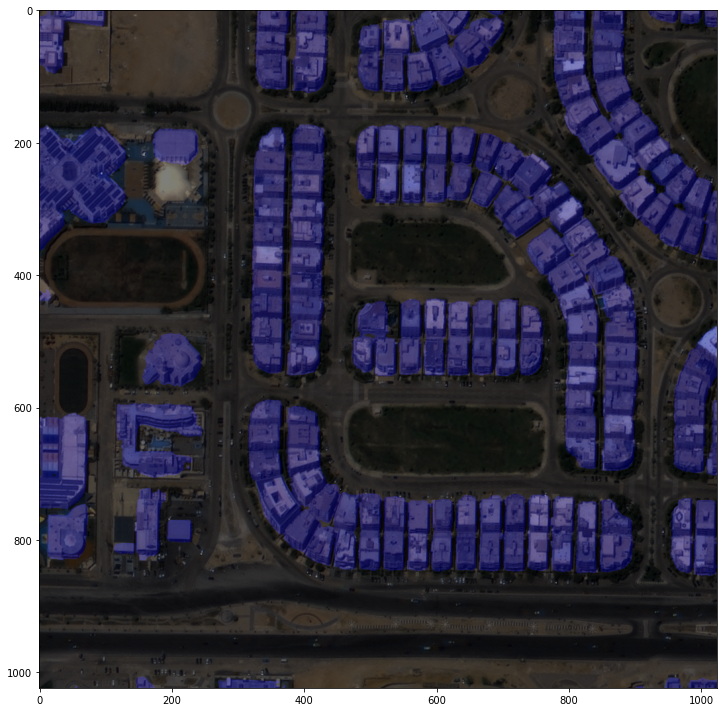

In [17]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


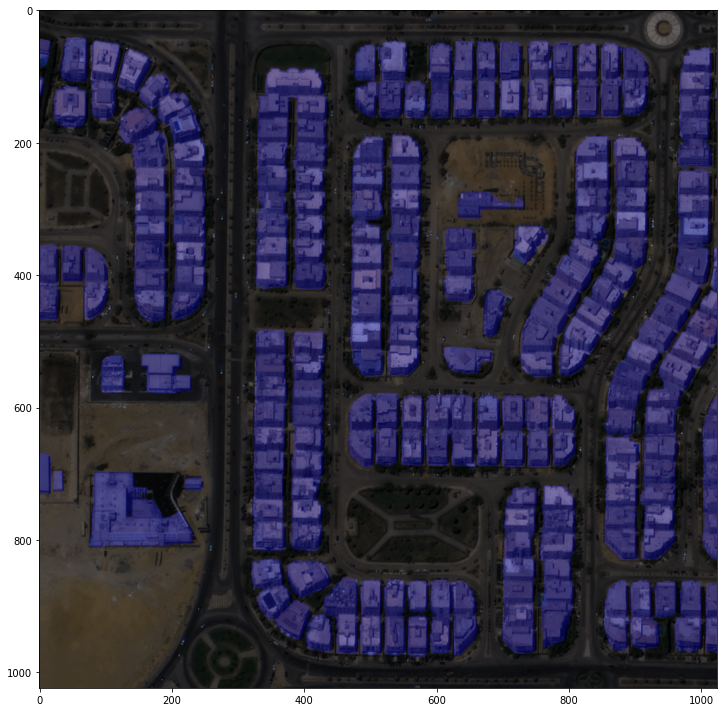

In [18]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


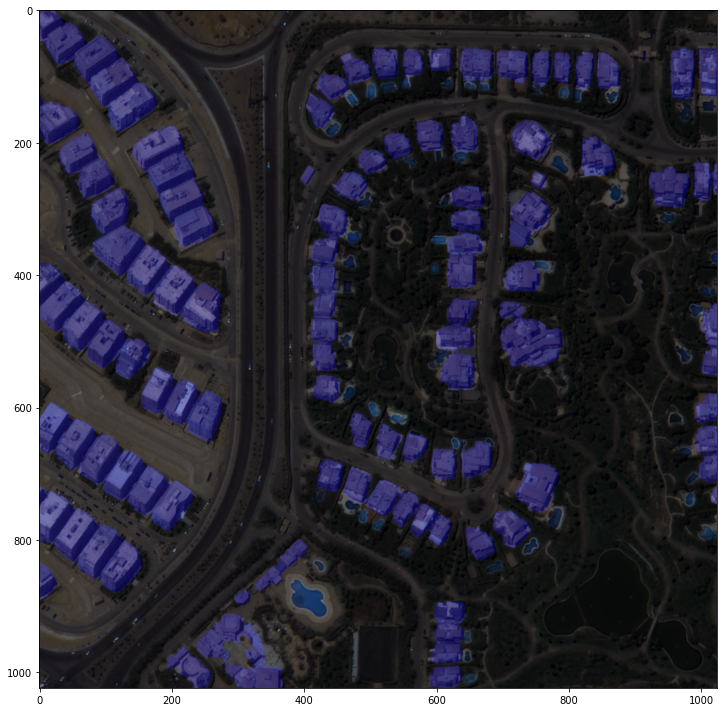

In [19]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


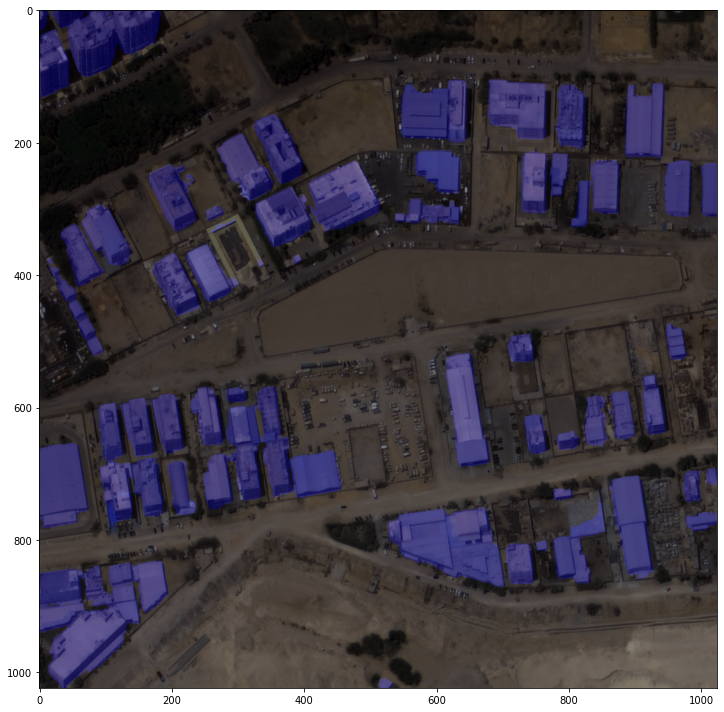

In [20]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_focal/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)